Problem :This project predicts whether a customer will churn using telecom data. Reducing churn helps companies retain valuable users and improve revenue

Solution:

In [ ]:
# import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, classification_report
import optuna
from optuna.visualization import plot_optimization_history, plot_slice, plot_param_importances

In [ ]:
# gathering data
df = pd.read_csv("customer_churn_dataset.csv")

Data Understanding

In [ ]:
# check top 2 rows of dataset
df.head(2)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0


In [ ]:
# drop irrelevant column
df.drop("CustomerID", axis=1, inplace=True)

In [ ]:
# check shape of dataset
df.shape

(505207, 11)

In [ ]:
# check data have null values or not
df.isnull().sum()

,0
Age,1
Gender,1
Tenure,1
Usage Frequency,1
Support Calls,1
Payment Delay,1
Subscription Type,1
Contract Length,1
Total Spend,1
Last Interaction,1


In [ ]:
# check data have duplicate rows ot not
df.duplicated().sum()

np.int64(0)

In [ ]:
# check data types of all features
df.dtypes

,0
Age,float64
Gender,object
Tenure,float64
Usage Frequency,float64
Support Calls,float64
Payment Delay,float64
Subscription Type,object
Contract Length,object
Total Spend,float64
Last Interaction,float64


In [ ]:
# some mathematical calculations on data
df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000
mean,39.704172,31.350435,15.714825,3.833317,13.496843,620.072766,14.610581,0.555203
std,12.670577,17.237482,8.619323,3.133603,8.451187,245.319256,8.608286,0.496944
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,8.000000,1.000000,6.000000,446.000000,7.000000,0.000000
50%,40.000000,32.000000,16.000000,3.000000,13.000000,648.900000,14.000000,1.000000
75%,49.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [ ]:
# value counts of categorical features
for col in df.columns:
    if df[col].dtypes == "object":
        print(df[col].value_counts())
        print()

Gender
Male      280273
Female    224933
Name: count, dtype: int64

Subscription Type
Standard    170630
Premium     170099
Basic       164477
Name: count, dtype: int64

Contract Length
Annual       198608
Quarterly    197364
Monthly      109234
Name: count, dtype: int64



Data Preprocessing

In [ ]:
# drop nan values
df.dropna(inplace=True)

In [ ]:
# type casting of numerical feature
for col in df.columns:
    if df[col].dtypes == "float64":
        df[col] = df[col].astype("int32")

Data Visualization

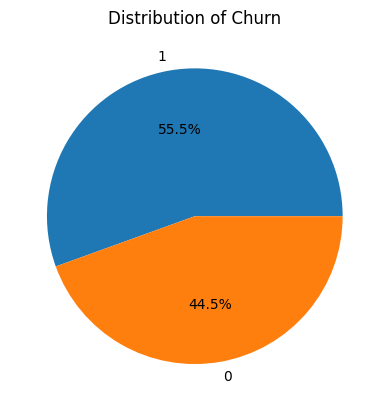

In [ ]:
# check dataset is balanced or not
plt.pie(df["Churn"].value_counts(), labels=df["Churn"].value_counts().index, autopct="%0.1f%%")
plt.title("Distribution of Churn")
plt.show()

The Dataset is balanced

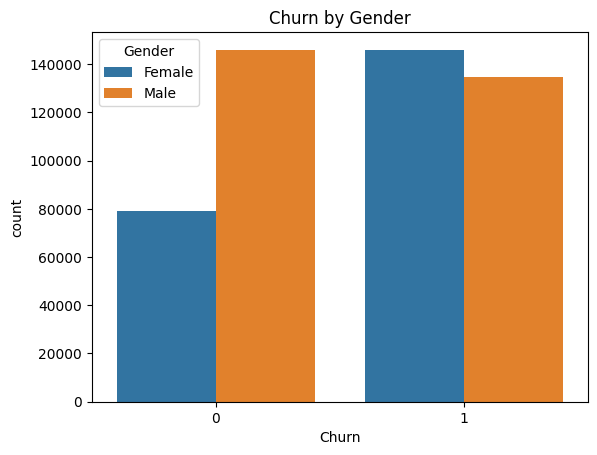

In [ ]:
# survival vs gender plot
sns.countplot(x=df["Churn"], hue=df["Gender"])
plt.title("Churn by Gender")
plt.show()

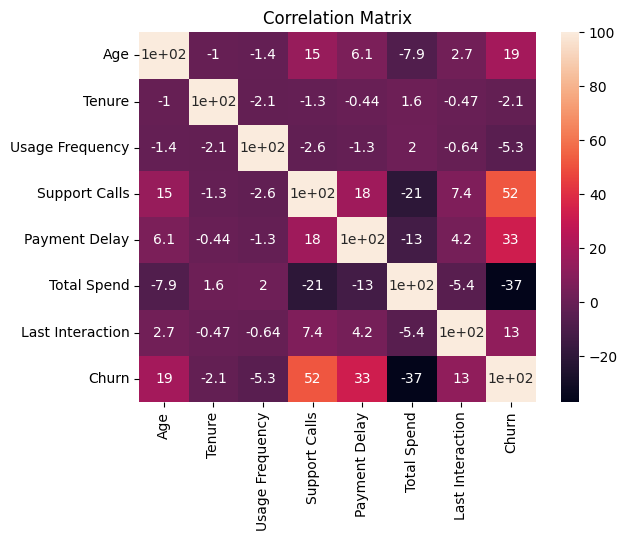

In [ ]:
 # correlation matrix
sns.heatmap(df.drop(["Gender", "Subscription Type", "Contract Length"], axis=1).corr()*100, annot=True)
plt.title("Correlation Matrix")
plt.show()

Preparing Data For Training And Evaluation

In [ ]:
# separating dependent and independent variable
x = df.iloc[:,:-1]
y = df["Churn"]

In [ ]:
# splitting data for training and testing
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

Checking Which Algorithm Is Suitable For Our Dataset

In [ ]:
# making Column Transformer for Pipeline
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["Gender"]),
    ("oe", OrdinalEncoder(categories=[["Basic", "Standard", "Premium"], ["Monthly", "Annual", "Quarterly"]]), ["Subscription Type", "Contract Length"])
], remainder="passthrough")

In [ ]:
# check cross validation score for a quick estimate
models = {
    "LogisticRegression" : LogisticRegression(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "xgboost" : XGBClassifier(),
    "lightgbm" : LGBMClassifier()
}

# mean accuracy
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("scaling", StandardScaler()),
        ("model", model)
    ])
    score = cross_val_score(pipe, x, y, cv=3).mean()
    print(f"{name}: {score}")

LogisticRegression: 0.8268884375878356
DecisionTreeClassifier: 0.8705557732885199
RandomForest: 0.9356955380577427
xgboost: 0.9323879763898292


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 186994, number of negative: 149810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 336804, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555201 -> initscore=0.221709
[LightGBM] [Info] Start training from score 0.221709


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 186995, number of negative: 149809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 336804, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555204 -> initscore=0.221721
[LightGBM] [Info] Start training from score 0.221721


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 186995, number of negative: 149809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 336804, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555204 -> initscore=0.221721
[LightGBM] [Info] Start training from score 0.221721


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lightgbm: 0.9357212701353509


Lightgbm, Xgboost and RandomForest- they perform good on our dataset.
So pick xgboost for our dataset

Model Tuning

In [ ]:
# creating objective function to find best parameter value
def objective(trial):

    # creating sample space
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    min_child_samples = trial.suggest_int("min_child_samples", 1, 200)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-5, 5.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 5.0, log=True)

    model = XGBClassifier(
        max_depth = max_depth,
        learning_rate = learning_rate,
        n_estimators = n_estimators,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        random_state = 42,
        n_jobs = -1
    )

    # creating pipeline
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # calculating f1_score
    pipe.fit(xtrain, ytrain)
    ypre = pipe.predict(xtest)
    score = f1_score(ytest, ypre)
    return score

In [ ]:
# finding best hyper Parameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# best hyper Parameters
print(f"best f1_score: {study.best_value}")
print(f"best hyper Parameters: {study.best_params}")

[I 2025-07-08 16:55:24,444] A new study created in memory with name: no-name-a72f6391-c3b2-4abd-bbe8-d69487550e48
[I 2025-07-08 16:56:02,458] Trial 0 finished with value: 0.9438185571461338 and parameters: {'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.03872774590150423, 'min_child_samples': 38, 'reg_alpha': 0.8396957856485467, 'reg_lambda': 0.308830728944859}. Best is trial 0 with value: 0.9438185571461338.
[I 2025-07-08 16:57:06,612] Trial 1 finished with value: 0.944 and parameters: {'n_estimators': 600, 'max_depth': 13, 'learning_rate': 0.013762266939350861, 'min_child_samples': 87, 'reg_alpha': 5.2285550070076224e-05, 'reg_lambda': 0.04883971255533112}. Best is trial 1 with value: 0.944.
[I 2025-07-08 16:59:15,078] Trial 2 finished with value: 0.9432915220825513 and parameters: {'n_estimators': 600, 'max_depth': 19, 'learning_rate': 0.012453632098645334, 'min_child_samples': 169, 'reg_alpha': 0.014296590693602266, 'reg_lambda': 0.004104221670568655}. Best is trial 1 with

best f1_score: 0.9444163548724172
best hyper Parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.019609168276579842, 'min_child_samples': 135, 'reg_alpha': 0.025660076518074056, 'reg_lambda': 1.5158888874455563}


Applying Some Visualizations To Imporove Sample Space For Tuning

In [ ]:
# trials vs f1_score
plot_optimization_history(study).show()

The performance is increasing very slowly, and it might continue to improve only slightly in the future as well.

In [ ]:
# check which values of hyper Parameters are important
fig = plot_slice(study)
fig.update_layout(title_text="Foused Values of HyperParameters")
fig.show()

In [ ]:
# importance of hyper Parameters in model
plot_param_importances(study).show()

Model Training

In [ ]:
# training model on their best hyper Parameters
model = XGBClassifier(
    max_depth = 10,
    learning_rate = 0.019609168276579842,
    n_estimators = 400,
    min_child_samples = 135,
    reg_alpha = 0.025660076518074056,
    reg_lambda = 1.5158888874455563,
    random_state = 42,
    n_jobs = -1
)

# creating pipeline
xgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

xgb_model.fit(xtrain, ytrain)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:35:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_child_samples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender']),
                                                 ('oe',
                                                  OrdinalEncoder(categories=[['Basic',
                                                                              'Standard',
                                                                              'Premium'],
                                                                             ['Monthly',
                                                                              'Annual',
                                                                              'Quarterly']]),
                                                  ['Subscription Type',
                                                   'Contract Length'])])),
                ('model',
                 XGBClassifier(base_score=None, boos...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.019609168276579842, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_samples=135,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

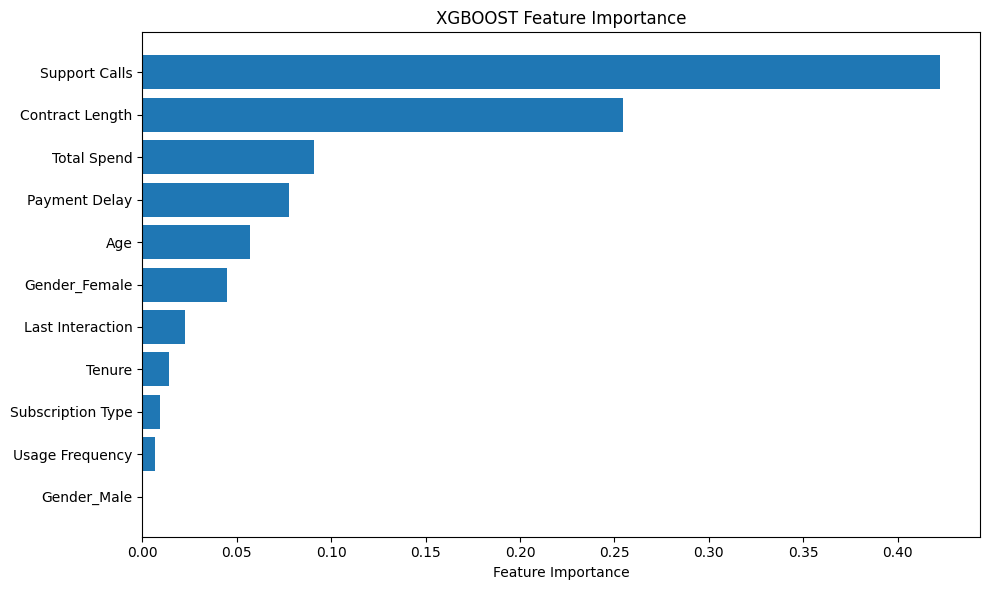

In [ ]:
# visualizing feature importance

# get features name
preprocessor = xgb_model.named_steps["preprocessor"]
ohe_columns = preprocessor.named_transformers_["ohe"].get_feature_names_out(["Gender"])

feature_names = list(ohe_columns) + ["Subscription Type", "Contract Length"] + \
                list(xtrain.drop(columns=["Gender", "Subscription Type", "Contract Length"]).columns)
model = xgb_model.named_steps["model"]

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("XGBOOST Feature Importance")
plt.tight_layout()
plt.show()

Model Evaluation

In [ ]:
# classification report of a model
ypre = xgb_model.predict(xtest)
classification_report(ytest, ypre)

'              precision    recall  f1-score   support\n\n           0       1.00      0.85      0.92     56160\n           1       0.90      1.00      0.94     70142\n\n    accuracy                           0.93    126302\n   macro avg       0.95      0.93      0.93    126302\nweighted avg       0.94      0.93      0.93    126302\n'

Result: After the overall process our model (xgb_model) is ready to predict chustomer will churn or not